In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

from torch.utils.data import Dataset, DataLoader, BatchSampler, random_split
from torchvision import transforms
from PIL import Image

In [2]:
%%capture
!pip install easyfsl

In [3]:
from tqdm import tqdm
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average
from torchvision.models import resnet18

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/NNDL_Project

Mounted at /content/drive
/content/drive/MyDrive/NNDL_Project


In [5]:
train_ann_df = pd.read_csv('train_data.csv')

In [6]:
train_ann_df.head()

,image,superclass_index,subclass_index
0,0.jpg,1,37
1,1.jpg,0,42
2,2.jpg,1,62
3,3.jpg,1,31
4,4.jpg,0,4


In [7]:
train_ann_df['superclass_index'].value_counts()

2    2388
1    2084
0    1850
Name: superclass_index, dtype: int64

In [8]:
train_ann_df['subclass_index'].value_counts()

37    102
35    102
66    102
22    102
49    102
     ... 
32     49
23     49
74     49
34     49
25     49
Name: subclass_index, Length: 87, dtype: int64

In [9]:
%%capture
! unzip -o train_shuffle.zip

In [10]:
%%capture
! unzip -o test_shuffle.zip

In [11]:
train_ann_df = pd.read_csv('train_data.csv')
super_map_df = pd.read_csv('superclass_mapping.csv')
sub_map_df = pd.read_csv('subclass_mapping.csv')

train_img_dir = 'train_shuffle'
test_img_dir = 'test_shuffle'

image_preprocessing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0), std=(1)),
])

In [54]:
# Create Dataset class for multilabel classification
class MultiClassImageDataset(Dataset):
    def __init__(self, ann_df, super_map_df, sub_map_df, img_dir, transform=None):
        self.ann_df = ann_df
        self.super_map_df = super_map_df
        self.sub_map_df = sub_map_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.ann_df)

    def __getitem__(self, idx):
        img_name = self.ann_df['image'][idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        super_idx = self.ann_df['superclass_index'][idx]
        super_label = self.super_map_df['class'][super_idx]

        sub_idx = self.ann_df['subclass_index'][idx]
        sub_label = self.sub_map_df['class'][sub_idx]

        if self.transform:
            image = self.transform(image)

        return image, int(sub_idx)

class MultiClassImageTestDataset(Dataset):
    def __init__(self, super_map_df, sub_map_df, img_dir, transform=None):
        self.super_map_df = super_map_df
        self.sub_map_df = sub_map_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self): # Count files in img_dir
        return len([fname for fname in os.listdir(self.img_dir)])

    def __getitem__(self, idx):
        img_name = str(idx) + '.jpg'
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name

In [55]:
train_dataset = MultiClassImageDataset(train_ann_df, super_map_df, sub_map_df, train_img_dir, transform=image_preprocessing)
test_dataset = MultiClassImageTestDataset(super_map_df, sub_map_df, test_img_dir, transform=image_preprocessing)

train_dataset, val_dataset = random_split(train_dataset, [0.5, 0.5])


# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True, drop_last = True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=True, drop_last = True)

test_loader = DataLoader(test_dataset,
                         batch_size=1,
                         shuffle=False)



In [56]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

In [57]:
convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PrototypicalNetworks(convolutional_network).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [60]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 5  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

In [61]:
val_dataset.get_labels = lambda: [instance[1] for instance in val_dataset]
val_sampler = TaskSampler(val_dataset, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS)
val_loader = DataLoader(
    val_dataset,
    batch_sampler=val_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)


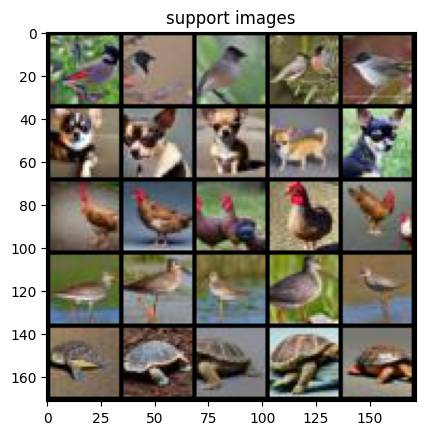

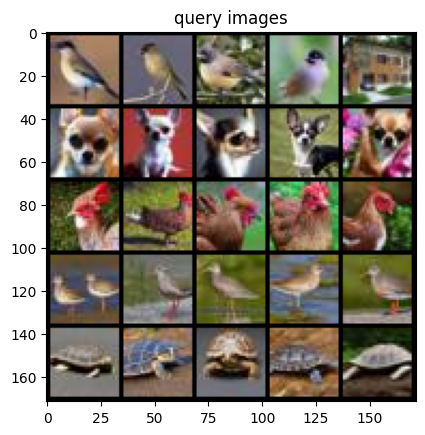

In [63]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(val_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [67]:
model.eval()
example_scores = model(
    example_support_images.to(device),
    example_support_labels.to(device),
    example_query_images.to(device),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

In [68]:
example_predicted_labels

tensor([0, 4, 3, 4, 3, 3, 3, 3, 3, 3, 1, 4, 1, 4, 1, 0, 2, 2, 2, 2, 0, 0, 4, 4,
        4])

In [72]:
print("Accuracy")
print(f'{100*torch.sum(example_query_labels==example_predicted_labels)/len(example_query_labels)}%')

Accuracy
64.0%


In [74]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.to(device), support_labels.to(device), query_images.to(device))
            .detach()
            .data,
            1,
        )[1]
        == query_labels.to(device)
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(val_loader)

100%|██████████| 100/100 [00:25<00:00,  3.90it/s]

Model tested on 100 tasks. Accuracy: 65.92%


In [80]:
N_TRAINING_EPISODES = 100 # was 40000 but decrease for fast experimentation
N_VALIDATION_TASKS = 100

train_dataset.get_labels = lambda: [instance[1] for instance in train_dataset]
train_sampler = TaskSampler(
    train_dataset, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [81]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.to(device), support_labels.to(device), query_images.to(device)
    )

    loss = criterion(classification_scores, query_labels.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()


In [82]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))




100%|██████████| 100/100 [01:32<00:00,  1.08it/s, loss=1.34]


In [83]:
evaluate(val_loader)

100%|██████████| 100/100 [00:29<00:00,  3.38it/s]

Model tested on 100 tasks. Accuracy: 51.16%
